In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
import joblib
import numpy as np

# Load processed dataset
df = pd.read_csv("data/HR_processed_data.csv")

# Clean column formatting
df["Orchard"] = df["Orchard"].astype(str).str.strip().str.title()
df["Variety"] = df["Variety"].astype(str).str.strip().str.title()

# Drop rows with missing target
df = df.dropna(subset=["HR Incidence"])

# Create binary classification target (adjust threshold if needed)
df["HR_Risk_High"] = (df["HR Incidence"] > 0.2).astype(int)

# Select categorical and top-ranked numeric features (as used in app)
categorical = ["Orchard", "Variety"]
numeric = [
    "Amt rain in last event>5days from assess",
    "Rain 3rd week  Jan",
    "Rain within 10 days of assessment",
    "No of rain days since 1 Jan",
    "Total rain Feb mm",
    "No rain days Feb"
]

# Drop rows with any missing selected numeric features
df = df.dropna(subset=numeric)

# Encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_cat = encoder.fit_transform(df[categorical])

# Combine encoded categorical with numeric features
X = np.hstack([X_cat, df[numeric].values])
y = df["HR_Risk_High"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train Random Forest model
base_model = RandomForestClassifier(random_state=42)
rf = CalibratedClassifierCV(base_model, method="sigmoid", cv=5)
rf.fit(X_train, y_train)

# Save model and encoder
joblib.dump(rf, "hr_risk_model.pkl")
joblib.dump(encoder, "encoder.pkl")

print("Random Forest model and encoder saved successfully.")

✅ Random Forest model and encoder saved successfully.


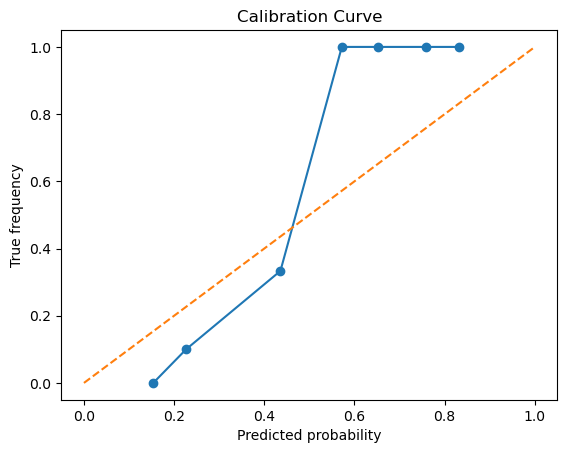

In [11]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

y_prob = rf.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("Predicted probability")
plt.ylabel("True frequency")
plt.title("Calibration Curve")
plt.show()